In [1]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=280)
from numba import jit
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
from typing import List, Dict
from recstate import C_, mu_, Sigma_, dC_, dmu_, dSigma_, RG, new_state, G_matrix

%load_ext autoreload
%autoreload 2

In [2]:
@jit(nopython = True)
def grad_state(gamma, phi, zeta, psi):
    """
    Gradient of the new state
    """
    
    C = C_(gamma, phi, zeta)
    dC = dC_(gamma, phi, zeta)
    mu = mu_(gamma, phi, zeta)
    dmu = dmu_(gamma, phi, zeta)
    Sigma = Sigma_(gamma, phi, zeta)
    dSigma = dSigma_(gamma, phi, zeta)
    
    R, G = RG(C, mu, Sigma, psi)
    
    cutoff = len(psi)
    dtype = psi.dtype
    sqrt = np.sqrt(np.arange(cutoff, dtype=dtype))
    order = None
    if order is None:
        order = cutoff
    
    dR = np.zeros((cutoff, cutoff, 5), dtype=dtype)
    dG = np.zeros((cutoff, 5), dtype=dtype)
    
    # grad of first row of Transformation matrix
    dG[0] = dC
    for n in range(cutoff-1):
        dG[n+1] = (dmu[1]*G[n] + mu[1]*dG[n] - dSigma[1,1]*sqrt[n]*G[n-1] - Sigma[1,1]*sqrt[n]*dG[n-1])/sqrt[n+1]
    
    # first row of dR matrix
    for n in range(cutoff):
        dR[0, n] = np.dot(np.transpose(dG[:cutoff - n]), psi)
        psi = psi[1:]*sqrt[1:cutoff-n]

    # rest of dR matrix
    for m in range(cutoff - 1):
        for k in range(cutoff - m - 1):
            dR[m+1, k] = (dmu[0]*R[m, k] + mu[0]*dR[m, k] - dSigma[0,0]*sqrt[m]*R[m-1, k] - Sigma[0,0]*sqrt[m]*dR[m-1, k] - Sigma[0,1]*dR[m, k+1] - dSigma[0,1]*R[m, k+1])/sqrt[m+1]
            
    return np.transpose(dR[:,0])

In [3]:
@tf.custom_gradient
def Ggate(gamma, phi, zeta, Psi):
    """
    Direct evolution of a quantum state
    """
    gamma = gamma.numpy()
    phi = phi.numpy()
    zeta = zeta.numpy()
    Psi = Psi.numpy()
    cutoff = Psi.shape[0]
    
    Psi_new = new_state(gamma, phi, zeta, Psi)
    
    def grad(dy):
        "Vector-Jacobian products for all the arguments (gamma, phi, zeta, Psi)"
        dPsi_dgamma, dPsi_dgammac, dPsi_dphi, dPsi_dz, dPsi_dzc = grad_state(gamma, phi, zeta, Psi) # gradients wrt g,g*,phi,z,z* 
        grad_gammac = tf.reduce_sum(dy*np.conj(dPsi_dgamma) + tf.math.conj(dy)*dPsi_dgammac)
        grad_phi = tf.math.real(tf.reduce_sum(dy*np.conj(dPsi_dphi))) # was *2
        grad_zetac = tf.reduce_sum(dy*np.conj(dPsi_dz) + tf.math.conj(dy)*dPsi_dzc)
        grad_Psic = tf.linalg.matvec(G_matrix(gamma, phi, zeta, cutoff), dy, adjoint_a=True)
        
        return grad_gammac, grad_phi, grad_zetac, grad_Psic
    
    return Psi_new, grad

def kerr(k, cutoff):
    diag = tf.exp(1j*tf.cast(k, dtype=tf.complex128)*np.arange(cutoff)**2)
    return diag

In [4]:
def init_complex(layers, scale=0.01):
    return np.random.normal(scale=scale, size=layers) + 1j*np.random.normal(scale=scale, size=layers)

def init_real(layers, scale=0.01):
    return np.random.normal(scale=scale, size=layers)

In [5]:
from dataclasses import dataclass, field

@dataclass
class Variables:
    gamma: tf.Variable
    phi: tf.Tensor
    zeta: tf.Variable
    kappa: tf.Variable
    
    @property
    def learnable(self):
        return [var for var in (self.gamma, self.phi, self.zeta, self.kappa) if isinstance(var, tf.Variable)]
    
    @property
    def all(self):
        return (self.gamma, self.phi, self.zeta, self.kappa)
    
    @property
    def L1_norm(self):
        tensor = tf.stack([tf.cast(var, tf.complex128) for var in self.all])
        return tf.abs(tf.linalg.norm(tensor, ord=1))

@dataclass
class Config:
    state_in:np.array
    objective:np.array
    dtype: tf.dtypes.DType
    num_layers: int
    steps: int
    optimizer: str = 'SGD'
    LR: float = 0.001
    LR_schedule: dict = field(default_factory=dict) # optional

In [6]:
class Circuit:
    def __init__(self, config:Config):
        self.config = config
        
        self.state_in = tf.cast(tf.constant(config.state_in), dtype=config.dtype)
        self.objective = tf.cast(tf.constant(config.objective), dtype=config.dtype)
        self._state_out = None
        
        self.cutoff = self.state_in.shape[0]
        self.optimizer = tf.optimizers.__dict__[config.optimizer](config.LR)
        
        gamma = tf.Variable(init_complex(self.config.num_layers, 0.01), dtype=tf.complex128, name=f'gamma')
        phi = tf.constant(init_real(self.config.num_layers), dtype=tf.float64, name=f'phi')
        zeta = tf.Variable(init_complex(self.config.num_layers, 0.01), dtype=tf.complex128, name=f'zeta')
        kappa = tf.Variable(init_real(self.config.num_layers, 0.01), dtype=tf.float64, name=f'kappa')
        
        self.variables = Variables(gamma, phi, zeta, kappa)
        

    def _layer_out(self, gamma: tf.Tensor, phi: tf.Tensor, zeta: tf.Tensor, k: tf.Tensor, layer_in: tf.Tensor) -> tf.Tensor:
        layer_out = Ggate(gamma, phi, zeta, layer_in)
        return kerr(k, self.cutoff)*layer_out
    
    @property # lazy property
    def state_out(self) -> tf.Tensor:
        if self._state_out is None: 
            state = self.state_in
            for i in range(self.config.num_layers):
                state = self._layer_out(self.variables.gamma[i], self.variables.phi[i], self.variables.zeta[i], self.variables.kappa[i], state)
            self._state_out = state
        return self._state_out
    
    @property
    def fidelity(self) -> tf.float64:
        return tf.abs(tf.reduce_sum(self.state_out*tf.math.conj(self.objective)))**2

    def loss(self) -> tf.float64:
        return 1.0 - self.fidelity

    def minimize_step(self) -> float:
        self._state_out = None # reset lazy output state
        self.optimizer.minimize(self.loss, self.variables.learnable)
        return self.loss()
        

    def minimize(self) -> list:
        
        loss_list = []
        for i in tqdm(range(self.config.steps)):
            try:
                loss_list.append(self.minimize_step())

                # LR scheduling
                for threshold, new_LR in self.config.LR_schedule.items():
                    if loss_list[-1] < threshold:
                        self.optimizer.lr = new_LR

                if i%10 == 0:
                    print(f"Fidelity = {100*(self.fidelity):.3f}%, LR = {self.optimizer.lr.numpy():.5f}", end='\r')

            except KeyboardInterrupt:
                break
            except Exception as e:
                print(f"other exception: {e}")
                raise e
        return loss_list

In [7]:
config = Config(
    state_in = np.identity(50)[0], # vacuum
    objective = np.identity(50)[1], # 1 photon
    dtype=tf.complex128,
    num_layers=8, 
    steps=500,
    optimizer='Adam', 
    LR=0.002, 
    LR_schedule={0.1:0.001, 0.05:0.001, 0.01:0.0005, 0.005:0.0001, 0.001:0.00005}
)

experiment = Circuit(config)

Fidelity = 99.813%, LR = 0.00010


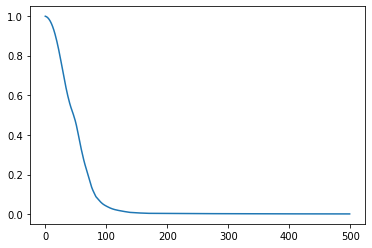

In [8]:
loss_list = experiment.minimize()
plt.plot(loss_list);